# Machine Learning 과정
- 문제정의
- 데이터 수집
- 데이터 전처리 (인코딩,특성공학)
- 탐색적 데이터 분석 (시각화, 특성선택)
- 모델 선택 및 학습
- 하이퍼파라미터 튜닝 (교차검증,그리드서치)
- 모델 평가

In [107]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [108]:
data = pd.read_csv('./data/train.csv')

In [109]:
data.shape

(891, 12)

In [110]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 데이터 사전
- PassengerId : 탑승객 id
- Survived : 생존여부 (0 = 사망, 1 = 생존)
- Pclass : 티켓 클래스 (1등급, 2등급, 3등급)
- Name : 이름
- Sex : 성별 (male = 남성, female = 여성)
- Age : 나이
- SibSp : 형제/배우자의 수
- Parch : 부모/자녀 수
- Ticket : 티켓 번호
- Fare : 요금
- Cabin : 객실번호
- Embarked : 승선항 C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 시각화 편의를 위해 Died 컬럼 추가

In [112]:
data['Died'] = 1 - data['Survived']

### 성별과의 관계

In [113]:
data.groupby('Sex').sum()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Died
Sex,,,,,,,,
female,135343,233,678,7286.00,218,204,13966.6628,81
male,262043,109,1379,13919.17,248,136,14727.2865,468


In [114]:
data.groupby('Sex').sum()[['Survived', 'Died']]

,Survived,Died
Sex,,
female,233,81
male,109,468


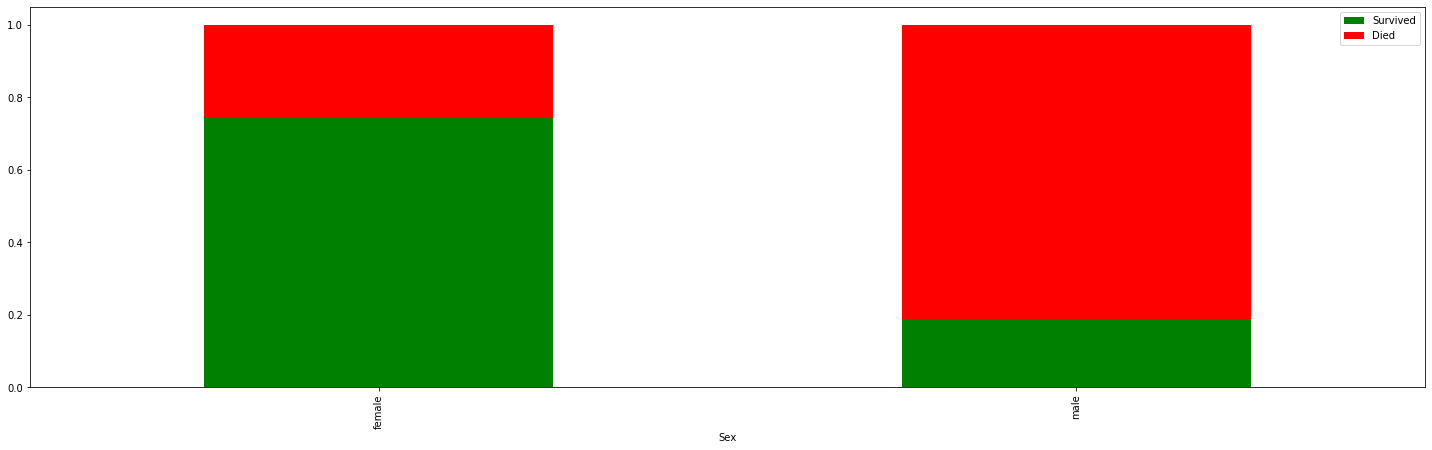

In [115]:
data.groupby('Sex').mean()[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), 
                                                           stacked=True, color=['g', 'r']);

남성이 많이 죽고 여성이 많이 살았다. (성별 컬럼은 생존과 관계가 많다)

### 나이와의 관계

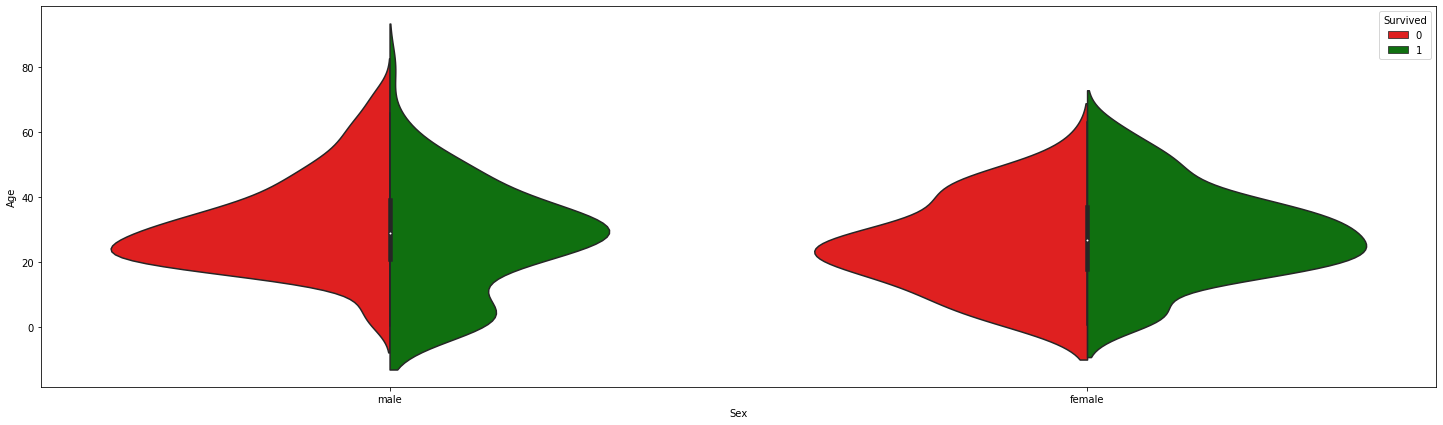

In [116]:
fig = plt.figure(figsize=(25, 7)) #그림 크기 지정
sns.violinplot(x='Sex', y='Age', #바이올린 그래프
               hue='Survived', data=data, 
               split=True,
               palette={0: "r", 1: "g"}
              )

- 남성 탑승객중 어린아이들이 조금 더 많이 살았다.
- 20~40 탑승객(남,여 모두)이 많이 사망했다.

### 요금과의 관계

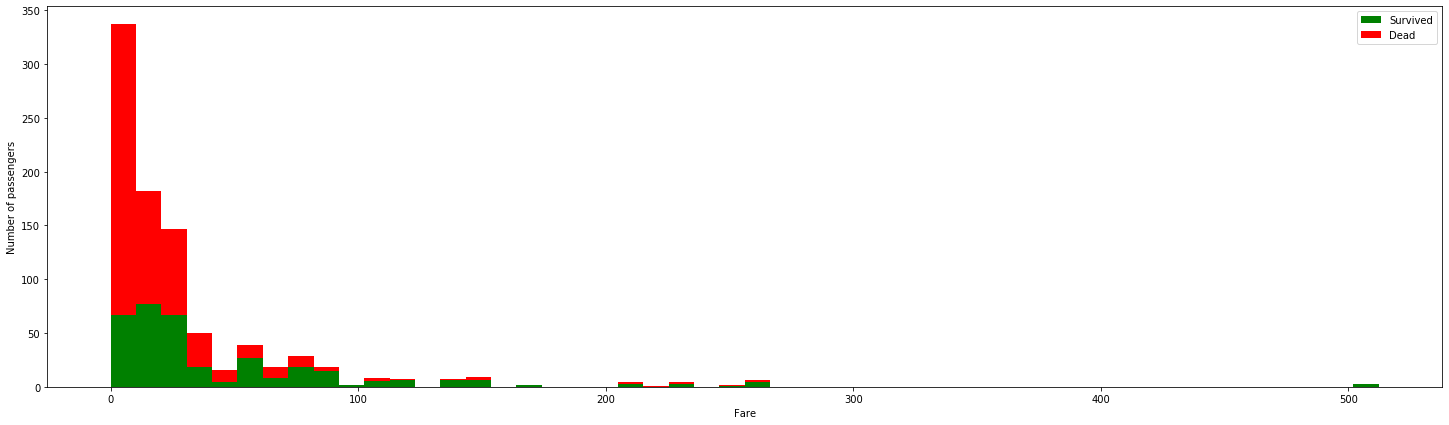

In [117]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

티켓 요금이 낮으면 많이 죽었다.

### 티켓요금과 선실등급과의 관계

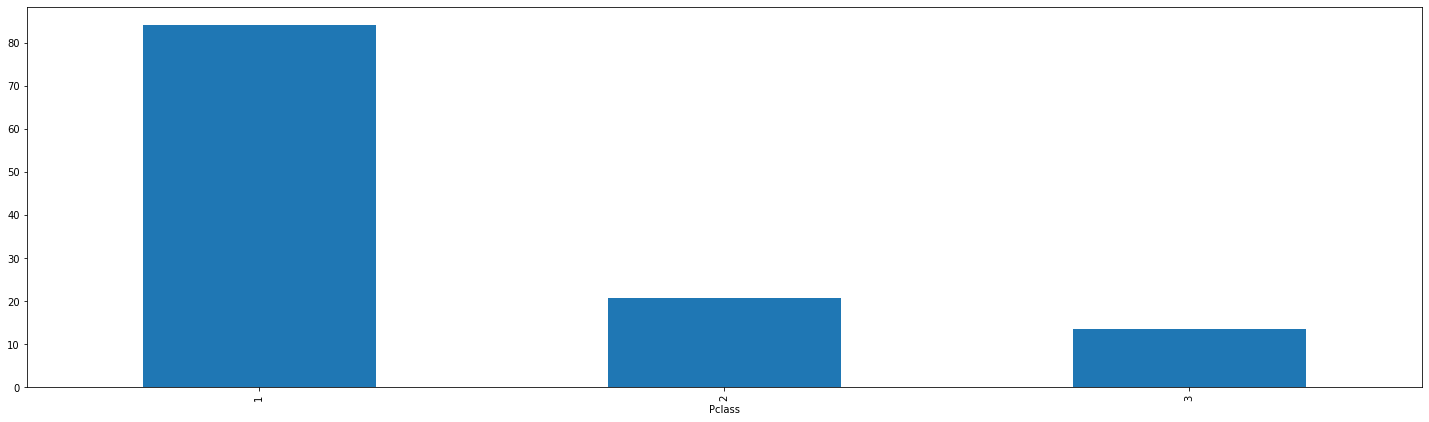

In [118]:
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7))

선실등급이 낮을 수록 티켓 가격이 싸다

### 승선항과의 관계

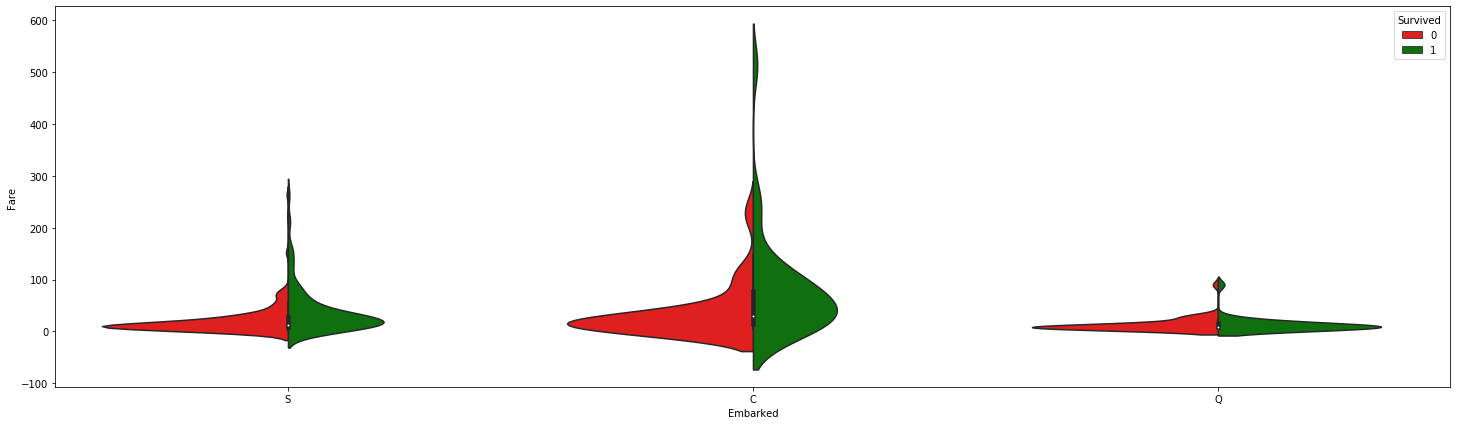

In [119]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data, split=True, palette={0: "r", 1: "g"});

- C,S는 요금 폭이 넓다
- 요금이 높은 사람들은 거의 죽지 않았다.

# Feature engineering

###  데이터로드
train과 test를 병합해서 사용(한번에 처리하기위해)

In [120]:
# train,test 데이터 로드
train = pd.read_csv('./data/train.csv')    
test = pd.read_csv('./data/test.csv')

# 생존여부를 별도로 분리
# inplace 속성으로 drop결과를 바로 적용
y_train = train["Survived"]
train.drop(['Survived'], axis = 1, inplace=True)
    
# 두 개의 데이터 병합 (concat 사용)
combined = pd.concat([train, test], axis=0)
    
# PassengerId는 삭제
combined.drop(['PassengerId'], axis=1, inplace=True)

#인덱스 재설정
combined.reset_index(drop=True, inplace=True)


In [121]:
combined.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [122]:
print("y_train 크기 확인 :",y_train.shape)
print("병합한 데이터 확인:",combined.shape)

y_train 크기 확인 : (891,)
병합한 데이터 확인: (1309, 10)


### 탑승객 호칭 처리

- Braund, <b> Mr.</b> Owen Harris	
- Heikkinen, <b>Miss.</b> Laina
- Oliva y Ocana, <b>Dona.</b> Fermina (귀부인)
- Peter, <b>Master.</b> Michael J (도련님)

In [123]:
s = 'Peter, Master. Michael J'
s.split(',')[1].split(".")[0].strip()

'Master'

In [124]:
def split_title(x):
    return x.split(',')[1].split('.')[0].strip()

In [125]:
titles = data["Name"].apply(split_title).unique()
titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

 - Mr : 남자
 - Mrs : 기혼여자
 - Miss : 미혼여자
 - Ms : 여자
 - Mlle : 아가씨
 - Mme : 영부인
 - Dona : 귀부인
 - Lady : 여자
 - the Countess : 여자 백작
 - Dr : 의사
 - Col : 대령
 - Major : 육군 소령
 - Jonkheer : 귀족
 - Capt : 육군 대위
 - Sir : ~경
 - Don : ~님

몇 개의 타이틀로 정리

- Officer (장교)
- Royalty (귀족)
- Mr
- Mrs
- Miss
- Master

In [126]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [127]:
combined['Title'] = combined["Name"].apply(split_title)
#map함수를 통해 딕셔너리의 키 값과 시리즈의 인덱스 값이 같은 데이터를 찾아 변경
combined['Title'] = combined["Title"].map(Title_Dictionary)

In [128]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


### 나이 처리

- 성별,선실등급,호칭으로 묶어서 평균나이를 구해보자

In [129]:
# as_index 속성으로 그룹을 묶는 컬럼을 인덱스에서 제외하자
#891까지 자르는 이유는 test에 train의 정보를 누수하는 느낌
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'],as_index = False)
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


성별과 선실등급 그리고 호칭에 따라 평균 나이가 조금씩 다르다.

In [130]:
def fill_age(row):
    condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Title'] == row['Title']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        ) 
    if np.isnan(row['Age']): 
        return grouped_median_train[condition]['Age'].values[0]
    else :
        return row['Age']#null이 아니라면 원래나이

In [131]:
combined['Age'] = combined.apply(fill_age, axis=1)

### 이름 처리
- 이름 특성 삭제
- 카테고리화 되어있는 호칭을 Model이 계산 할 수 있도록 one-hot-encoding

In [132]:
#이름 특성 삭제
combined.drop('Name', axis=1, inplace=True)

In [133]:
titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
titles_dummies.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [134]:
combined = pd.concat([combined, titles_dummies], axis=1)
combined.drop('Title', axis=1, inplace=True)

In [135]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


### 요금 처리

In [136]:
combined["Fare"].fillna(combined["Fare"].mean(), inplace=True)

### 승선항 처리

- 결측치는 많은 사람들이 탑승한 S로 채운다
- encoding

In [137]:
combined.iloc[:891].Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [138]:
# 결측치 처리
combined["Embarked"].fillna('S', inplace=True)
    
# one-hot-encoding
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)

# 승선항 특성 삭제
combined.drop('Embarked', axis=1, inplace=True)

In [139]:
combined.head(10)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1
5,3,male,26.0,0,0,330877,8.4583,NaN,0,0,1,0,0,0,0,1,0
6,1,male,54.0,0,0,17463,51.8625,E46,0,0,1,0,0,0,0,0,1
7,3,male,2.0,3,1,349909,21.0750,NaN,1,0,0,0,0,0,0,0,1
8,3,female,27.0,0,2,347742,11.1333,NaN,0,0,0,1,0,0,0,0,1
9,2,female,14.0,1,0,237736,30.0708,NaN,0,0,0,1,0,0,1,0,0


### 객실번호 
- 결측치는 U(Uknown)로 대체
- 숫자를 제거한 맨 앞 글자로 변경
- encoding

In [140]:
# 결측치는 U로 대체
combined['Cabin'].fillna('U',inplace=True)

In [141]:
# Cabin의 첫 글자로 변경
combined['Cabin'] = combined['Cabin'].str[0]

In [142]:
# one-hot-encoding
cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
combined = pd.concat([combined, cabin_dummies], axis=1)

# Cabin 특성 삭제
combined.drop('Cabin', axis=1, inplace=True)

In [143]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


### 성별 처리

In [144]:
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})

남성은 1 여성은 0으로 변경

In [145]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,1,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,0,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,0,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,1,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


### 객실등급 처리

In [146]:
# one-hot-encoding
pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
combined = pd.concat([combined, pclass_dummies],axis=1)
    
# 객실등급 특성 삭제
combined.drop('Pclass',axis=1,inplace=True)

In [147]:
combined.head()

,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,1,0,A/5 21171,7.2500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0,38.0,1,0,PC 17599,71.2833,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,35.0,1,0,113803,53.1000,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,1,35.0,0,0,373450,8.0500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


### 티켓 처리

filter : 두번째 인수인 반복 가능한 자료형 요소들을 첫번째 인자 함수에 하나씩 입력하여 리턴값이 참인 것만 묶어서 돌려준다.

### filter와 isdigit()함수 테스트

In [148]:
ticket = ['A/5 21171','STON/O2 .3101282     ','113803']
list(map(lambda t : t.strip(), ticket))

['A/5 21171', 'STON/O2 .3101282', '113803']

In [149]:
ticket = [t.strip() for t in ticket]
ticket

['A/5 21171', 'STON/O2 .3101282', '113803']

In [150]:
ticket1 = list(filter(lambda t : not t.isdigit(), ticket))
ticket1

['A/5 21171', 'STON/O2 .3101282']

### -----------------------------------

In [151]:
def cleanTicket(ticket):
    # .과/를 없애준다.
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    
    # 공백 기준으로 자른다.
    ticket = ticket.split()

    # 자른 리스트의 각 항목의 양쪽 공백을 없애준다.
    ticket = [t.strip() for t in ticket] #map(lambda t : t.strip(), ticket)
    
    # 숫자가 아닌 것만 필터링해서 리스트로 만듬
    # isdigit 숫자로만 구성된 문자열을 감지
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX' #티켓 글자가 없으면 XXX로 표시

In [152]:
combined['Ticket'] = combined['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
combined = pd.concat([combined, tickets_dummies], axis=1)
combined.drop('Ticket', inplace=True, axis=1)

In [153]:
combined.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### 가족관련 특성 처리
- 부모,자녀,배우자,형제 모두 합친 특성을 새롭게 만듬
- 가족 숫자에 따라 1인, 소규모 가족, 대규모 가족으로 구분

In [154]:
# 본인을 포함하여 모든 가족수 특성 생성
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

# map함수는 apply처럼 함수를 넣어서 사용가능
# lambda는 간단한 함수를 줄여서 쓰는 방식
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

In [155]:
combined.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


# Modeling

In [156]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

train과 test를 분리

In [157]:
X_train = combined.iloc[:891]
X_test = combined.iloc[891:]

In [158]:
X_train.shape, y_train.shape

((891, 67), (891,))

# Randomforest로 가장 영향력있는 가중치 확인

In [181]:
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [182]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = model.feature_importances_#feature별 가중치 크기
features.head(3)

,feature,importance
0,Sex,0.104126
1,Age,0.200734
2,SibSp,0.023624


In [183]:
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

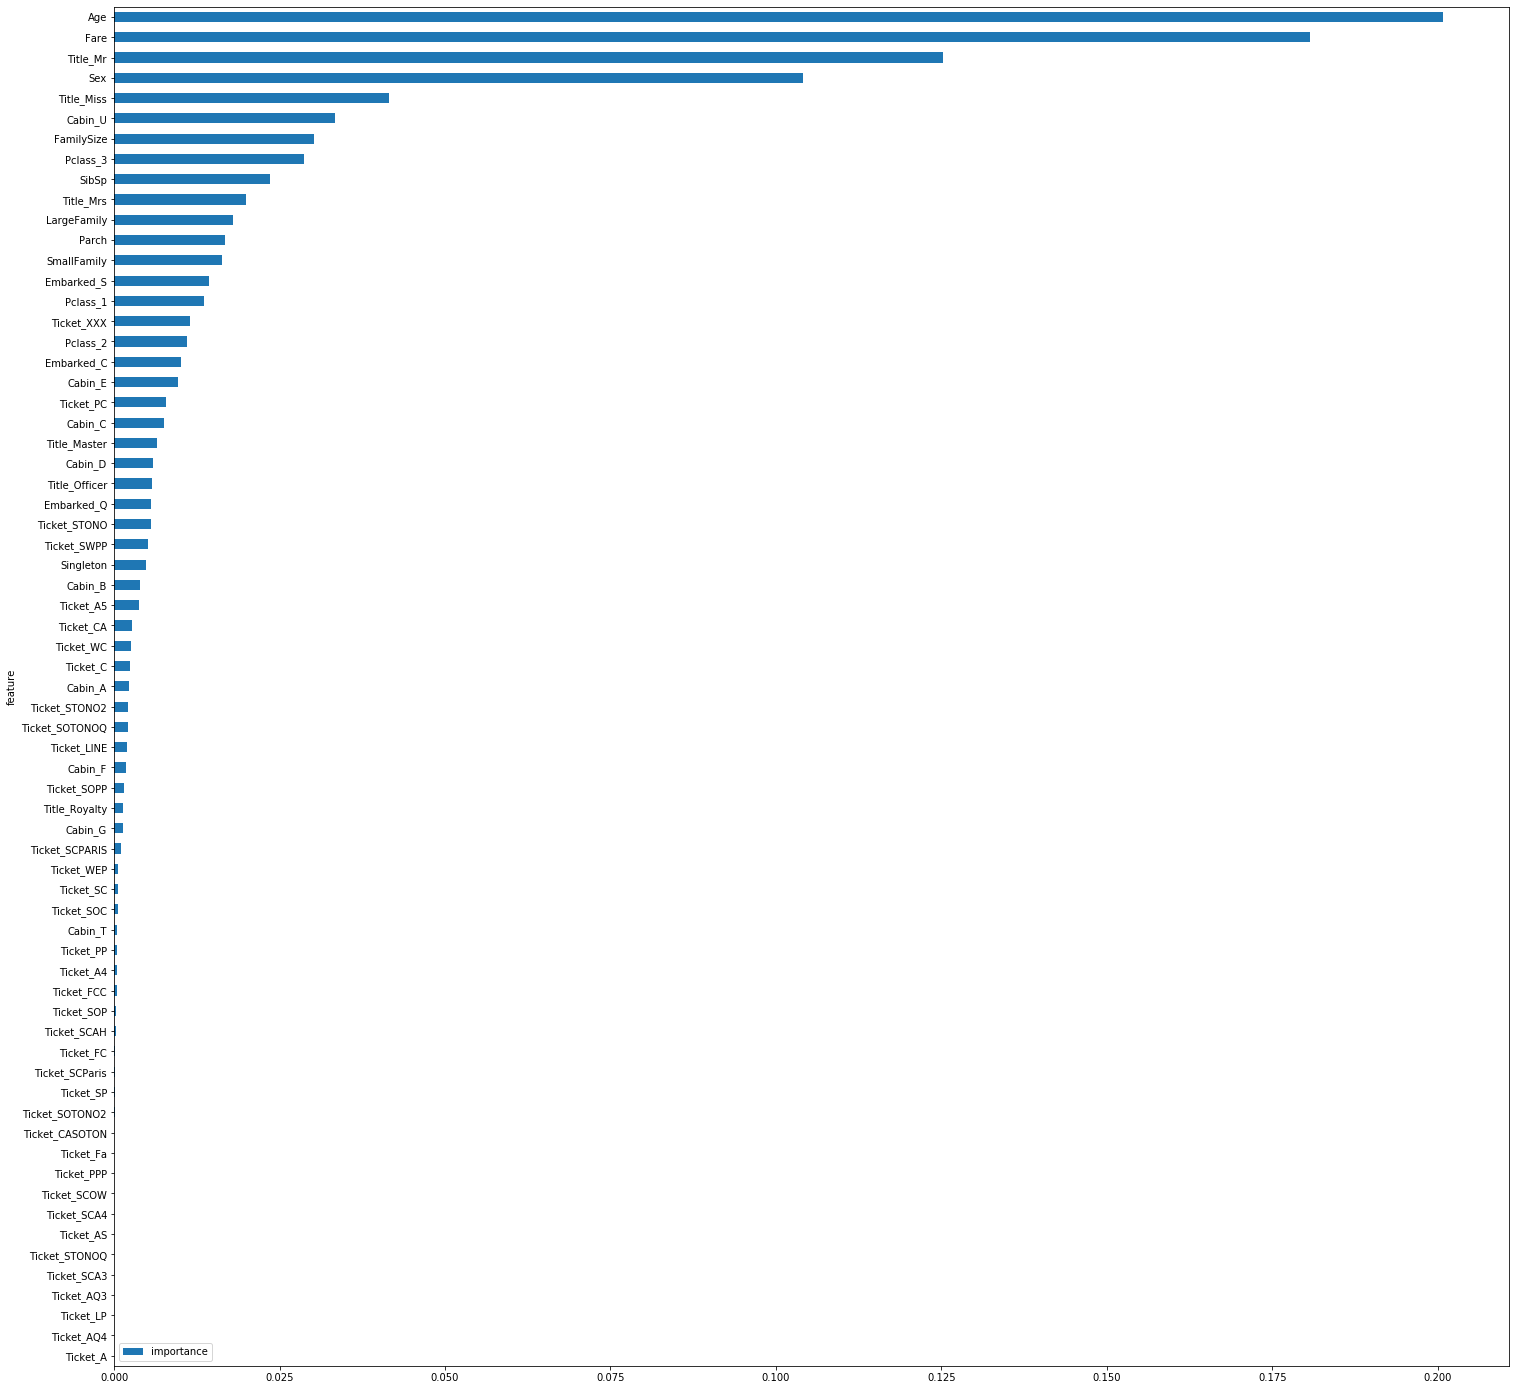

In [184]:
features.plot(kind='barh', figsize=(25, 25))

Title_Mr, Age, Fare, Sex 등이 중요한 특성으로 나타난다

# 중요도 가중치에 따라 기능 선택하는 메타 변압기

In [185]:
from sklearn.feature_selection import SelectFromModel
select_model = SelectFromModel(model, prefit=True)

# 모든 특성 중요도 값의 평균 이상인 특성들을 선택
# threshold를 이용해 임계치 지정가능
X_train_reduced = select_model.transform(X_train)
X_train_reduced.shape

(891, 13)

In [186]:
X_test_reduced = select_model.transform(X_test)
X_test_reduced.shape

(418, 13)

In [208]:
model.fit(X_train_reduced, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [209]:
model.score(X_train_reduced,y_train)

0.9865319865319865

In [210]:
predict_result = model.predict(X_test_reduced)

In [211]:
df_output = pd.DataFrame()#캐글에 올릴 데이터 만듬
aux = pd.read_csv('./data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = predict_result
df_output.to_csv('result_submit.csv',index=False)

# 최적의 하이퍼 파라메터 찾기 GridSearch이용

In [212]:
from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier(random_state=92)
param_grid = {'max_depth': [3,5,7,9], # 트리의 노드 깊이
             "n_estimators":[10,30,50,100], # 트리의 개수
             "max_features":[0.2,0.4,0.6], # 하나의 노드에서 고려될 특성의 범위(0.2 = 전체 특성 중 20%만 선택)
             'min_samples_leaf': [10,30,50] # 리프 노드에서 최소 존재해야할 샘플의 개수 (과대적합을 보완해줌)
             }
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train_reduced, y_train)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수: ", grid.best_params_)

최상의 크로스 밸리데이션 점수: 0.83
최적의 매개변수:  {'max_depth': 5, 'max_features': 0.4, 'min_samples_leaf': 10, 'n_estimators': 100}


In [213]:
#최상의 결과로 예측
final_model = RandomForestClassifier(
    bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    ##random_state=92,max_depth=5,max_features=0.4,min_samples_leaf=10,n_estimators=100
final_model.fit(X_train_reduced, y_train)
predict_result = final_model.predict(X_test_reduced)
df_output = pd.DataFrame()
aux = pd.read_csv('./data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = predict_result
df_output.to_csv('result_submit.csv',index=False)

# 히트맵 그리기 / 수업 X
### "max_depth","max_features" 기준으로

In [171]:
grid.cv_results_# 그리드 서치의 모든 정보

{'mean_fit_time': array([0.01595778, 0.03970618, 0.06442895, 0.15835643, 0.01694937,
        0.05565825, 0.07360177, 0.16557083, 0.01635361, 0.03709083,
        0.06262679, 0.12986135, 0.02313704, 0.04826899, 0.07558608,
        0.16634898, 0.01595736, 0.0464745 , 0.07420745, 0.14839544,
        0.01456027, 0.04588213, 0.08357086, 0.14082808, 0.02891865,
        0.06144285, 0.08756514, 0.16057792, 0.01775274, 0.05565095,
        0.07339988, 0.1454114 , 0.0159708 , 0.04248638, 0.09753981,
        0.17773204, 0.01396179, 0.05327516, 0.06364989, 0.13623528,
        0.01275802, 0.04488525, 0.08516512, 0.13822384, 0.0135633 ,
        0.03610325, 0.05606022, 0.11428847, 0.01496696, 0.04109674,
        0.07739787, 0.15179162, 0.01396184, 0.03710823, 0.0759923 ,
        0.12127633, 0.01276646, 0.05584278, 0.08478208, 0.14300938,
        0.01697011, 0.04387517, 0.07858791, 0.17094088, 0.01655593,
        0.04269519, 0.07081723, 0.14320884, 0.02253242, 0.04629078,
        0.06901522, 0.12785211,

In [141]:
score = pd.DataFrame(grid.cv_results_['params'])
score["mean_test_score"]=grid.cv_results_['mean_test_score']
score

,max_depth,max_features,min_samples_leaf,n_estimators,mean_test_score
0,3,0.2,10,10,0.787879
1,3,0.2,10,30,0.800224
2,3,0.2,10,50,0.805836
3,3,0.2,10,100,0.809203
4,3,0.2,30,10,0.758698
5,3,0.2,30,30,0.792368
6,3,0.2,30,50,0.792368
7,3,0.2,30,100,0.789001
8,3,0.2,50,10,0.754209
9,3,0.2,50,30,0.783389


In [142]:
group1 = score.groupby(as_index=False,by=["max_depth","max_features"]).mean()
group1

,max_depth,max_features,min_samples_leaf,n_estimators,mean_test_score
0,3,0.2,30.0,47.5,0.786476
1,3,0.4,30.0,47.5,0.799663
2,3,0.6,30.0,47.5,0.807800
3,5,0.2,30.0,47.5,0.796109
4,5,0.4,30.0,47.5,0.802376
5,5,0.6,30.0,47.5,0.808736
6,7,0.2,30.0,47.5,0.796483
7,7,0.4,30.0,47.5,0.800599
8,7,0.6,30.0,47.5,0.808455
9,9,0.2,30.0,47.5,0.797138


In [143]:
s1 = group1["mean_test_score"].reshape(-1, 3)
s1

C:\Users\MH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


array([[0.78647587, 0.7996633 , 0.80780022],
       [0.79610924, 0.80237561, 0.8087355 ],
       [0.79648335, 0.80059858, 0.80845492],
       [0.79713805, 0.80115975, 0.80751964]])

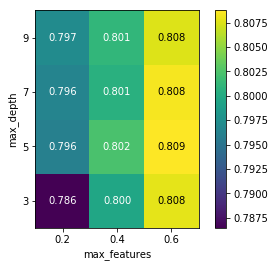

In [144]:
import mglearn

heatmap = mglearn.tools.heatmap(
    s1, xlabel="max_features", ylabel="max_depth", cmap="viridis", fmt="%.3f",
    xticklabels=[0.2,0.4,0.6],
    yticklabels=[3,5,7,9])
plt.colorbar(heatmap)

In [145]:
group2 = score.groupby(as_index=False,by=["n_estimators","min_samples_leaf"]).mean()
group2

,n_estimators,min_samples_leaf,max_depth,max_features,mean_test_score
0,10,10,6,0.4,0.815657
1,10,30,6,0.4,0.788066
2,10,50,6,0.4,0.774878
3,30,10,6,0.4,0.820801
4,30,30,6,0.4,0.798541
5,30,50,6,0.4,0.786008
6,50,10,6,0.4,0.823793
7,50,30,6,0.4,0.801534
8,50,50,6,0.4,0.787411
9,100,10,6,0.4,0.823232


In [146]:
s2 = group2["mean_test_score"].reshape(-1, 3)
s2

C:\Users\MH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


array([[0.81565657, 0.78806584, 0.77487841],
       [0.8208006 , 0.79854097, 0.78600823],
       [0.82379349, 0.80153386, 0.78741115],
       [0.82323232, 0.80527497, 0.78731762]])

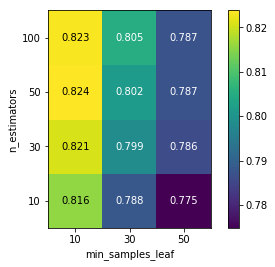

In [147]:
heatmap = mglearn.tools.heatmap(
    s2, xlabel="min_samples_leaf", ylabel="n_estimators", cmap="viridis", fmt="%.3f",
    xticklabels=[10,30,50],
    yticklabels=[10,30,50,100])
plt.colorbar(heatmap)

In [148]:
from sklearn.model_selection import GridSearchCV
m = RandomForestClassifier(random_state=92)
param_grid = {'max_depth': [3,5,7,9], # 트리의 노드 깊이
             "n_estimators":[120,150,200], # 트리의 개수
             "max_features":[0.2,0.4,0.6], # 하나의 노드에서 고려될 특성의 범위(0.2 = 전체 특성 중 20%만 선택)
             'min_samples_leaf': [3,5,7] # 리프 노드에서 최소 존재해야할 샘플의 개수 (과대적합을 보완해줌)
             }
grid = GridSearchCV(m, param_grid, cv=5)
grid.fit(train_reduced, targets)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수: ", grid.best_params_)

최상의 크로스 밸리데이션 점수: 0.84
최적의 매개변수:  {'max_depth': 9, 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 120}


In [150]:
final_model = RandomForestClassifier(random_state=92,max_depth=5,max_features=0.4,min_samples_leaf=7,n_estimators=120)
final_model.fit(train_reduced, targets)
predict_result = final_model.predict(test_reduced)
df_output = pd.DataFrame()
aux = pd.read_csv('./data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = predict_result
df_output.to_csv('result_submit.csv',index=False)